In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import json
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


## Configuration

In [2]:
# Paths
DATASET_PATH = Path(r'C:\Users\phoga\Desktop\HemoPrint\dataset')
PREP_PATH = Path(r'C:\Users\phoga\Desktop\HemoPrint\model_results\preprocessing')
MODEL2_PATH = Path(r'C:\Users\phoga\Desktop\HemoPrint\model_results\model2_vgg16')
MODEL2_PATH.mkdir(parents=True, exist_ok=True)

# Load preprocessing config
with open(PREP_PATH / 'config.json', 'r') as f:
    config = json.load(f)

BLOOD_GROUPS = config['classes']
NUM_CLASSES = config['num_classes']
IMAGE_SIZE = config['image_size']
BATCH_SIZE = config['batch_size']

# Training parameters
EPOCHS = 30
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 1e-4

print(f"Classes: {NUM_CLASSES}")
print(f"Image size: {IMAGE_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")

Classes: 8
Image size: 224
Epochs: 30
Learning rate: 0.0001


## Load Data

In [3]:
# Load splits
train_df = pd.read_csv(PREP_PATH / 'train_split.csv')
val_df = pd.read_csv(PREP_PATH / 'val_split.csv')
test_df = pd.read_csv(PREP_PATH / 'test_split.csv')

# Load class weights
class_weights_df = pd.read_csv(PREP_PATH / 'class_weights.csv')
class_weights = torch.FloatTensor(class_weights_df['weight'].values).to(device)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 4200, Val: 900, Test: 900


## Dataset & DataLoaders

In [4]:
class BloodDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img = Image.open(self.df.iloc[idx]['path']).convert('RGB')
        label = self.df.iloc[idx]['label']
        if self.transform:
            img = self.transform(img)
        return img, label

# Transforms
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets and loaders
train_dataset = BloodDataset(train_df, train_transform)
val_dataset = BloodDataset(val_df, test_transform)
test_dataset = BloodDataset(test_df, test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 66
Val batches: 15
Test batches: 15


## Model: VGG-16

In [5]:
# Load pretrained VGG-16
model = models.vgg16(pretrained=True)

# Freeze only the feature extraction layers
for param in model.features.parameters():
    param.requires_grad = False

# Keep classifier layers trainable (except we'll replace the last one)
# Replace final classifier for our 8 classes
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, NUM_CLASSES)

model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: VGG-16 (Transfer Learning)")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")
print(f"\nNote: Features frozen, Classifier trainable for better accuracy")

Model: VGG-16 (Transfer Learning)
Total parameters: 134,293,320
Trainable parameters: 119,578,632
Frozen parameters: 14,714,688

Note: Features frozen, Classifier trainable for better accuracy


## Loss & Optimizer

In [6]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Mixed precision training
scaler = torch.cuda.amp.GradScaler()

print("Loss: CrossEntropyLoss with class weights")
print("Optimizer: Adam")
print("Scheduler: ReduceLROnPlateau")
print("Mixed Precision: Enabled")

Loss: CrossEntropyLoss with class weights
Optimizer: Adam
Scheduler: ReduceLROnPlateau
Mixed Precision: Enabled


## Training Functions

In [7]:
def train_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Mixed precision forward pass
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        # Mixed precision backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            
            # Mixed precision inference
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(loader), 100. * correct / total

print("Training functions defined (with mixed precision)")

Training functions defined (with mixed precision)


## Train Model

In [8]:
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0.0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    scheduler.step(val_loss)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL2_PATH / 'best_model.pth')
        print(f"✓ Best model saved! Val Acc: {val_acc:.2f}%")

print(f"\nTraining complete! Best Val Acc: {best_val_acc:.2f}%")


Epoch 1/30


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.07it/s]



Train Loss: 1.4832, Train Acc: 39.24%
Val Loss: 1.4160, Val Acc: 43.00%
✓ Best model saved! Val Acc: 43.00%

Epoch 2/30
✓ Best model saved! Val Acc: 43.00%

Epoch 2/30


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.32it/s]



Train Loss: 1.1176, Train Acc: 52.07%
Val Loss: 1.1253, Val Acc: 51.22%
✓ Best model saved! Val Acc: 51.22%

Epoch 3/30
✓ Best model saved! Val Acc: 51.22%

Epoch 3/30


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s]



Train Loss: 0.9741, Train Acc: 59.98%
Val Loss: 1.0242, Val Acc: 53.56%
✓ Best model saved! Val Acc: 53.56%

Epoch 4/30
✓ Best model saved! Val Acc: 53.56%

Epoch 4/30


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.19it/s]



Train Loss: 0.7865, Train Acc: 67.48%
Val Loss: 0.8953, Val Acc: 64.89%
✓ Best model saved! Val Acc: 64.89%

Epoch 5/30
✓ Best model saved! Val Acc: 64.89%

Epoch 5/30


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s]



Train Loss: 0.6737, Train Acc: 72.81%
Val Loss: 0.7133, Val Acc: 74.22%
✓ Best model saved! Val Acc: 74.22%

Epoch 6/30
✓ Best model saved! Val Acc: 74.22%

Epoch 6/30


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]


Train Loss: 0.5919, Train Acc: 77.00%
Val Loss: 0.7213, Val Acc: 69.78%

Epoch 7/30


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s]



Train Loss: 0.5220, Train Acc: 79.45%
Val Loss: 0.6681, Val Acc: 74.56%
✓ Best model saved! Val Acc: 74.56%

Epoch 8/30
✓ Best model saved! Val Acc: 74.56%

Epoch 8/30


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]



Train Loss: 0.5071, Train Acc: 79.38%
Val Loss: 0.5512, Val Acc: 78.89%
✓ Best model saved! Val Acc: 78.89%

Epoch 9/30
✓ Best model saved! Val Acc: 78.89%

Epoch 9/30


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


Train Loss: 0.4718, Train Acc: 80.86%
Val Loss: 0.6051, Val Acc: 75.11%

Epoch 10/30


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


Train Loss: 0.4370, Train Acc: 82.67%
Val Loss: 0.7330, Val Acc: 74.11%

Epoch 11/30


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.16it/s]


Train Loss: 0.4288, Train Acc: 83.14%
Val Loss: 0.6753, Val Acc: 74.78%

Epoch 12/30


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s]


Train Loss: 0.4115, Train Acc: 83.71%
Val Loss: 0.5729, Val Acc: 78.11%

Epoch 13/30


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s]


Train Loss: 0.4069, Train Acc: 83.67%
Val Loss: 0.5590, Val Acc: 78.56%

Epoch 14/30


Validation: 100%|██████████| 15/15 [00:13<00:00,  1.12it/s]



Train Loss: 0.4125, Train Acc: 82.69%
Val Loss: 0.6319, Val Acc: 78.56%

Epoch 15/30


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Train Loss: 0.3571, Train Acc: 86.21%
Val Loss: 0.5726, Val Acc: 78.89%

Epoch 16/30


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.16it/s]



Train Loss: 0.3264, Train Acc: 87.40%
Val Loss: 0.5597, Val Acc: 79.56%
✓ Best model saved! Val Acc: 79.56%

Epoch 17/30
✓ Best model saved! Val Acc: 79.56%

Epoch 17/30


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]



Train Loss: 0.3193, Train Acc: 87.07%
Val Loss: 0.5157, Val Acc: 80.33%
✓ Best model saved! Val Acc: 80.33%

Epoch 18/30
✓ Best model saved! Val Acc: 80.33%

Epoch 18/30


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.13it/s]



Train Loss: 0.3207, Train Acc: 87.69%
Val Loss: 0.5150, Val Acc: 80.44%
✓ Best model saved! Val Acc: 80.44%

Epoch 19/30
✓ Best model saved! Val Acc: 80.44%

Epoch 19/30


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.16it/s]



Train Loss: 0.2934, Train Acc: 88.69%
Val Loss: 0.4967, Val Acc: 80.89%
✓ Best model saved! Val Acc: 80.89%

Epoch 20/30
✓ Best model saved! Val Acc: 80.89%

Epoch 20/30


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.05it/s]



Train Loss: 0.2963, Train Acc: 88.50%
Val Loss: 0.4853, Val Acc: 81.56%
✓ Best model saved! Val Acc: 81.56%

Epoch 21/30
✓ Best model saved! Val Acc: 81.56%

Epoch 21/30


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Train Loss: 0.2835, Train Acc: 89.02%
Val Loss: 0.4911, Val Acc: 79.67%

Epoch 22/30


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.15it/s]


Train Loss: 0.2911, Train Acc: 88.05%
Val Loss: 0.5142, Val Acc: 80.67%

Epoch 23/30


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


Train Loss: 0.2800, Train Acc: 88.74%
Val Loss: 0.5281, Val Acc: 80.22%

Epoch 24/30


Validation: 100%|██████████| 15/15 [00:07<00:00,  1.99it/s]


Train Loss: 0.2719, Train Acc: 89.21%
Val Loss: 0.5116, Val Acc: 81.22%

Epoch 25/30


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.14it/s]


Train Loss: 0.2594, Train Acc: 90.05%
Val Loss: 0.5416, Val Acc: 80.00%

Epoch 26/30


Validation: 100%|██████████| 15/15 [00:08<00:00,  1.82it/s]


Train Loss: 0.2721, Train Acc: 88.67%
Val Loss: 0.5544, Val Acc: 80.78%

Epoch 27/30


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.08it/s]



Train Loss: 0.2535, Train Acc: 90.33%
Val Loss: 0.4920, Val Acc: 83.56%
✓ Best model saved! Val Acc: 83.56%

Epoch 28/30
✓ Best model saved! Val Acc: 83.56%

Epoch 28/30


Validation: 100%|██████████| 15/15 [00:07<00:00,  2.06it/s]


Train Loss: 0.2341, Train Acc: 90.60%
Val Loss: 0.4971, Val Acc: 82.22%

Epoch 29/30


Validation: 100%|██████████| 15/15 [00:08<00:00,  1.77it/s]


Train Loss: 0.2420, Train Acc: 90.55%
Val Loss: 0.4675, Val Acc: 81.78%

Epoch 30/30


Validation: 100%|██████████| 15/15 [00:06<00:00,  2.26it/s]

Train Loss: 0.2160, Train Acc: 91.52%
Val Loss: 0.4934, Val Acc: 82.00%

Training complete! Best Val Acc: 83.56%


## Plot Training History

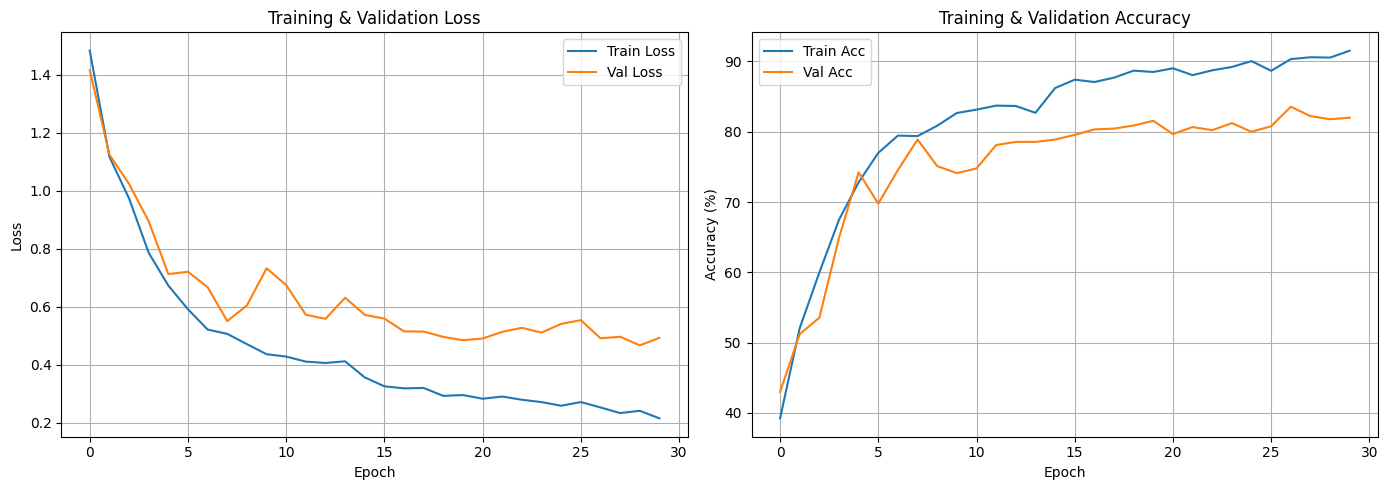

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss')
ax1.legend()
ax1.grid(True)

# Accuracy
ax2.plot(history['train_acc'], label='Train Acc')
ax2.plot(history['val_acc'], label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training & Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.savefig(MODEL2_PATH / 'training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## Evaluate on Test Set

In [10]:
# Load best model
model.load_state_dict(torch.load(MODEL2_PATH / 'best_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing'):
        images = images.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate metrics
test_acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=BLOOD_GROUPS))

# Save report
report = classification_report(all_labels, all_preds, target_names=BLOOD_GROUPS, output_dict=True)
pd.DataFrame(report).transpose().to_csv(MODEL2_PATH / 'classification_report.csv')

Testing: 100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


Test Accuracy: 81.89%

Classification Report:
              precision    recall  f1-score   support

          A+       0.84      0.86      0.85        85
          A-       0.78      0.85      0.81       151
         AB+       0.90      0.80      0.85       106
         AB-       0.79      0.80      0.79       114
          B+       0.79      0.84      0.81        98
          B-       0.84      0.87      0.86       111
          O+       0.81      0.79      0.80       128
          O-       0.83      0.75      0.79       107

    accuracy                           0.82       900
   macro avg       0.82      0.82      0.82       900
weighted avg       0.82      0.82      0.82       900



## Confusion Matrix

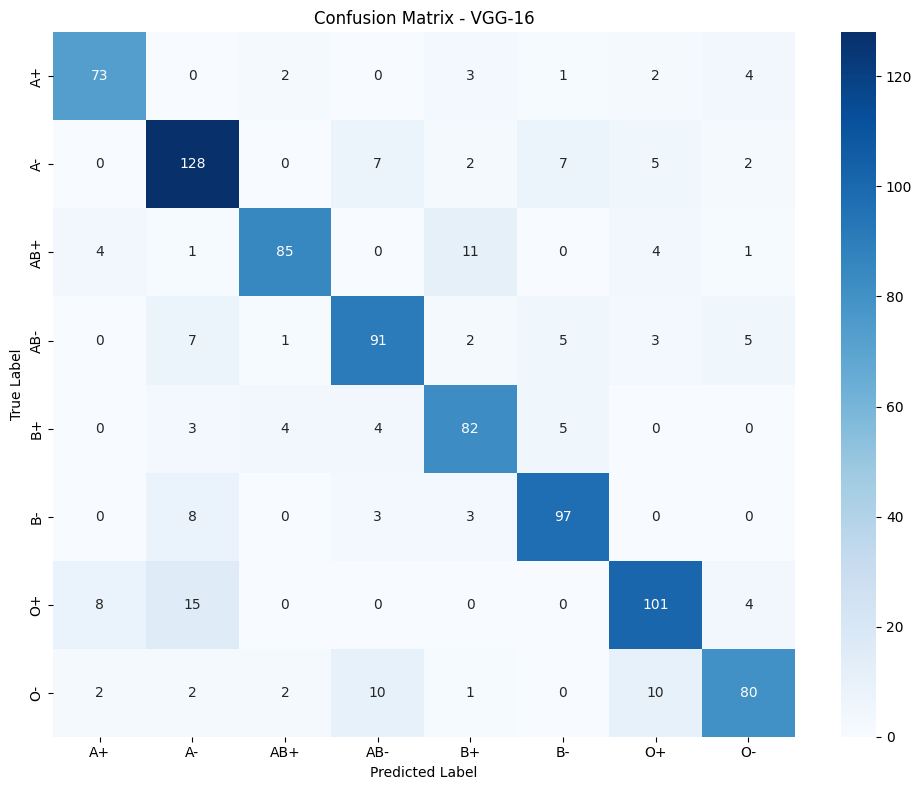

In [11]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=BLOOD_GROUPS, yticklabels=BLOOD_GROUPS)
plt.title('Confusion Matrix - VGG-16')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(MODEL2_PATH / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Save confusion matrix
pd.DataFrame(cm, index=BLOOD_GROUPS, columns=BLOOD_GROUPS).to_csv(MODEL2_PATH / 'confusion_matrix.csv')

## Save Results

In [12]:
# Save training history
pd.DataFrame(history).to_csv(MODEL2_PATH / 'training_history.csv', index=False)

# Save final results
results = {
    'model': 'VGG-16',
    'epochs': EPOCHS,
    'learning_rate': LEARNING_RATE,
    'batch_size': BATCH_SIZE,
    'best_val_acc': best_val_acc,
    'test_acc': test_acc * 100,
    'total_params': sum(p.numel() for p in model.parameters()),
    'trainable_params': sum(p.numel() for p in model.parameters() if p.requires_grad)
}

with open(MODEL2_PATH / 'results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n" + "="*60)
print("MODEL 2 (VGG-16) COMPLETE")
print("="*60)
print(f"Best Val Accuracy: {best_val_acc:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"\nAll results saved to: {MODEL2_PATH}")
print("="*60)


MODEL 2 (VGG-16) COMPLETE
Best Val Accuracy: 83.56%
Test Accuracy: 81.89%

All results saved to: C:\Users\phoga\Desktop\HemoPrint\model_results\model2_vgg16
